<a href="https://colab.research.google.com/github/ace-aitech/ML-Airbnb-Paris_Analytics_and_Predictions/blob/main/airbnb_paris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Machine Learning</center></h1>
<h2><center> Airbnb Data Analysis and Price Prediction Quarters Q2-Q4 2022 </center> </h2>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
!pip install pandas==1.5.3

In [ ]:
# %%capture
!pip install scipy==1.10.1

In [ ]:
# %%capture
!pip install joblib

In [ ]:
# %%capture
!pip install geopandas
!pip3 install contextily

In [ ]:
# %%capture
!pip install missingno

In [ ]:
# !pip install sentence-transformers
%cd '/content/drive/MyDrive/airbnb'

/content/drive/MyDrive/airbnb


## 1. Introduction

__Airbnb__, Inc. is an American San Francisco-based company operating an online marketplace for short-term homestays and experiences. The company acts as a broker and charges a commission from each booking.  The company not only have revolutionized the tourism industry but has also been facilitated an unaffordable increase in home rents, and for a lack of regulation (https://en.wikipedia.org/wiki/Airbnb).

With this in mind, the objectives of these project are:

* Visualise the properties offered in the 20 Arrondissements of Paris during Quarters Q2 - Q4 of 2022 
* Find features that impact the price of a listing
* Identify potential inactive listing with outlier prices - noise 
* Identify the most expensive and cheapest neighbourhoods
* Identyfied the type of accommodations and properties more often offered by airbnb
* Identify listing that offered for long-term stays 
* Predict the price of accommodation



Airbnb datasets Q2-Q4 2022 can be sourced from  http://insideairbnb.com/get-the-data/

### 1.1 Libraries and frameworks

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import joblib
# import missingno as msno
from pandas.tseries.offsets import DateOffset


from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression, SelectPercentile
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor  # VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skorch import NeuralNetRegressor

import torch
from torch import nn


# metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

%matplotlib inline


## 2. Dataset

### 2.1 Creating directory for datasets and downlading data

In [ ]:
paris_dir = os.path.join(os.getcwd(), 'datasets', 'paris')
try:
    os.makedirs(paris_dir, exist_ok=False)
except OSError as error:
    print('Directory already exist')

Directory already exist


In [ ]:
# Creat directory to save figures
plots_dir = os.path.join(os.getcwd(), 'figures')
try:
    os.makedirs(plots_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')
    

Directory already exist


### 2.2 Frequenty function clean data and save plots

In [ ]:
# Drop columns and rows functions
def drop_columns(col_list=None, df=None):

    df.drop(col_list, axis=1, inplace=True)

def drop_rows(indices=None, df=None):
    df.drop(index=indices, inplace=True)


In [ ]:
def save_plot(plot_name, x=None, y=None):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    return plt.close()

### 2.3 Download the data

The dasets for q2, q3 and q4 will be dowloaded an concatenated.

In [ ]:
# Uncomment to download
download = False
if download:
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/data/listings.csv.gz -O 'datasets/paris/listings_q4.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q4.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q4.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/data/listings.csv.gz -O 'datasets/paris/listings_q3.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q3.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q3.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/listings.csv.gz -O 'datasets/paris/listings_q2.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q2.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q2.csv'


### 2.4 Load datasets from csv file

In [ ]:
df_q2 = pd.read_csv(os.path.join(paris_dir, 'listings_q2.csv.gz'), compression='gzip')
df_q3 = pd.read_csv(os.path.join(paris_dir, 'listings_q3.csv.gz'), compression='gzip')
df_q4 = pd.read_csv(os.path.join(paris_dir, 'listings_q4.csv.gz'), compression='gzip')

In [ ]:
# Extract the number of features in each quarter
f2 = df_q2.columns
f3 = df_q3.columns
f4 = df_q4.columns

print(f'Are the features in df_q2 equal to the features in df_q3? {len(f2) == len(f3)}')
print(f'Are the features in df_q3 equal to the features in df_q4? {len(f3) == len(f4)}')

Are the features in df_q2 equal to the features in df_q3? False
Are the features in df_q3 equal to the features in df_q4? True


In [ ]:
# find the features in df_q3 that are not in df_q2
drop_cols= list()
for f in f3:
    if f not in f2:
        print(f'drop column: "{f}" from df_q3 and df_q4')
        drop_cols.append(f)        

drop column: "source" from df_q3 and df_q4


In [ ]:
# Drop column source to concatenate the three datsets in one
for c in drop_cols:
    df_q3.drop(c, axis=1, inplace=True)
    df_q4.drop(c, axis=1, inplace=True)

df_paris = pd.concat([df_q2, df_q3, df_q4], ignore_index=True)
print(f'Dataset features: {len(df_paris)}')


Dataset features: 173208


In [ ]:
def data_summary(df, plot_dir=plots_dir, name=None):
    """ 
    Function to summarise features and properties with missing features
    """
     
    # find unique listing by id
    properties = len(df.id.unique())
    
    # find the number of features with nan values per accomodation
    nan_per_accomodation = df.isna().sum(axis=1)
    
    # Uniquenumber of features missing
    missing_features = np.unique(nan_per_accomodation)
    
    print(f'Accomodations: {len(df)} | Unique accomodations: {properties}')
    print(f'Dataset features including id: {len(df.columns)} | Accomodations missing features: {len(nan_per_accomodation)}') 
    
    # Visualise the distribution of propertings per missing features
    if 0 in nan_per_accomodation.value_counts().keys():
         nan_per_accomodation.value_counts()[1:].plot.bar(color='green', fontsize=10, figsize=(5,3))
    
    else:
        nan_per_accomodation.value_counts().plot.bar(color='green', fontsize=10, figsize=(5,3))
    plt.title('Missing features in accomodation')
    plt.ylabel('listings count')
    plt.xlabel('missing features')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{name}.jpg'), bbox_inches='tight',
                    format='jpg')
    plt.close()
    
    return nan_per_accomodation, missing_features
    

In [ ]:
print('======== Summary before data cleaning, wrangling and data engineering ========')
missing_features, unique_misses = data_summary(df_paris, name='init-hist')


======== Summary before data cleaning, wrangling and data engineering ========
Accomodations: 173208 | Unique accomodations: 73122
Dataset features including id: 74 | Accomodations missing features: 173208


 <img align="left" src='figures/init-hist.jpg' width=500/>

In [ ]:
df_paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173208 entries, 0 to 173207
Data columns (total 74 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            173208 non-null  int64  
 1   listing_url                                   173208 non-null  object 
 2   scrape_id                                     173208 non-null  int64  
 3   last_scraped                                  173208 non-null  object 
 4   name                                          173086 non-null  object 
 5   description                                   171099 non-null  object 
 6   neighborhood_overview                         100156 non-null  object 
 7   picture_url                                   173205 non-null  object 
 8   host_id                                       173208 non-null  int64  
 9   host_url                                      17

**Plot here**
<img src='figures/init-hist.jpg' width='400'/>


- Unique Accommodations 73122 in Q2-Q4
- All accomodations 173208
- All listing have at least one feture missing.
- Most of the listing miss 20 or less features, 


## 3. Visualisation of listings spread in Paris

In [ ]:
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
import contextily as cx

- Only visualise the unique properties advertise in Q2-Q4 2022
- Use geopandas, folium and context geo tiles (contextily) to read  and visualise the geolocation of each neighbourhood
- plot the propertieslocation

### 3.1 Interactive localisation - GIS

In [ ]:
property_gis = df_paris.copy()[['id', 'neighbourhood_cleansed','latitude', 'longitude', 
                      'price']]
property_gis.drop_duplicates(subset='id', inplace=True)
gis = gpd.read_file(os.path.join(paris_dir, 'neighbourhoods_q4.geojson'))

In [ ]:
acc_coords = property_gis[['latitude', 'longitude']].values.tolist()
coord_size = len(acc_coords)

In [ ]:
paris_coor = [48.85341, 2.3488]
paris_map = folium.Map(width=800, height=500, location=paris_coor, tiles='openstreetmap', 
                       zoom_start=11)

for i, geo in enumerate(gis.geometry.values):
    geo_j = folium.GeoJson(data=geo, 
                       style_function=lambda x:{'fillColor': 'blue'})
    folium.Popup(gis.neighbourhood[i]).add_to(geo_j)
    geo_j.add_to(paris_map)
FastMarkerCluster(acc_coords, radius=0.5).add_to(paris_map)
paris_map.save(os.path.join(plots_dir, 'geomap.html'))


In [ ]:
paris_map


- Interactive map of the Paris airbnb listings: https://github.com/ace-aitech/ML-Airbnb-Paris_Analytics_and_Predictions/geomap.html


### 3.2  Mercador location coordinates  of  the listings and neighboourhoods

In [ ]:
def listings_gis(df, col_name='neighbourhood', title=None, plot_name=None, coordinates=None):

    gdf = gpd.GeoDataFrame(df, crs=4326, geometry=gpd.points_from_xy(df.longitude, 
                                                df.latitude))
    # Convert coordinates to Mercador coordinates
    neigh=coordinates.to_crs(epsg=3857)
    listings=gdf.to_crs(epsg=3857)
    ax=neigh.plot(column=col_name, alpha=0.7, legend=True,
                cmap='tab20', figsize=(20, 20), edgecolor='black')
    listings.plot(ax=ax, alpha=0.2, color='blue', marker='o', markersize=2,
                          figsize=(20, 20), legend=False)
    cx.add_basemap(ax)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    plt.close()
    

In [ ]:
title = 'Listing distribution in Paris Neighbourhoods'
gis_name = 'paris_listings'
listings_gis(property_gis, col_name='neighbourhood', title=title, plot_name=gis_name, 
             coordinates=gis)

In [ ]:
(property_gis.neighbourhood_cleansed.value_counts()/len(property_gis)).plot.bar(color='green', fontsize=8, 
                                                            figsize=(5, 3))
plt.grid()
save_plot('neighbourhood_listings', x='neighbourhood_cleansed', y='listings density')

**To see the map and bar chart uncomment the markdown code in this cell**
<!-- <img align="left" src='figures/paris_listings.jpg' width=500/><img align="right" src='figures/neighbourhood_listings.jpg' width=350/>  -->



## 4. Features exploration

### 4.1 Summary of features

In [ ]:
# Convert strings to dates
date_time_cols = ['host_since', 'first_review', 'last_review', 'last_scraped', 
                  'calendar_last_scraped']
df_paris[date_time_cols] = df_paris[date_time_cols].apply(pd.to_datetime)

In [ ]:
# Types of data in the dataset
df_paris.dtypes.value_counts()

object            29
float64           23
int64             17
datetime64[ns]     5
dtype: int64

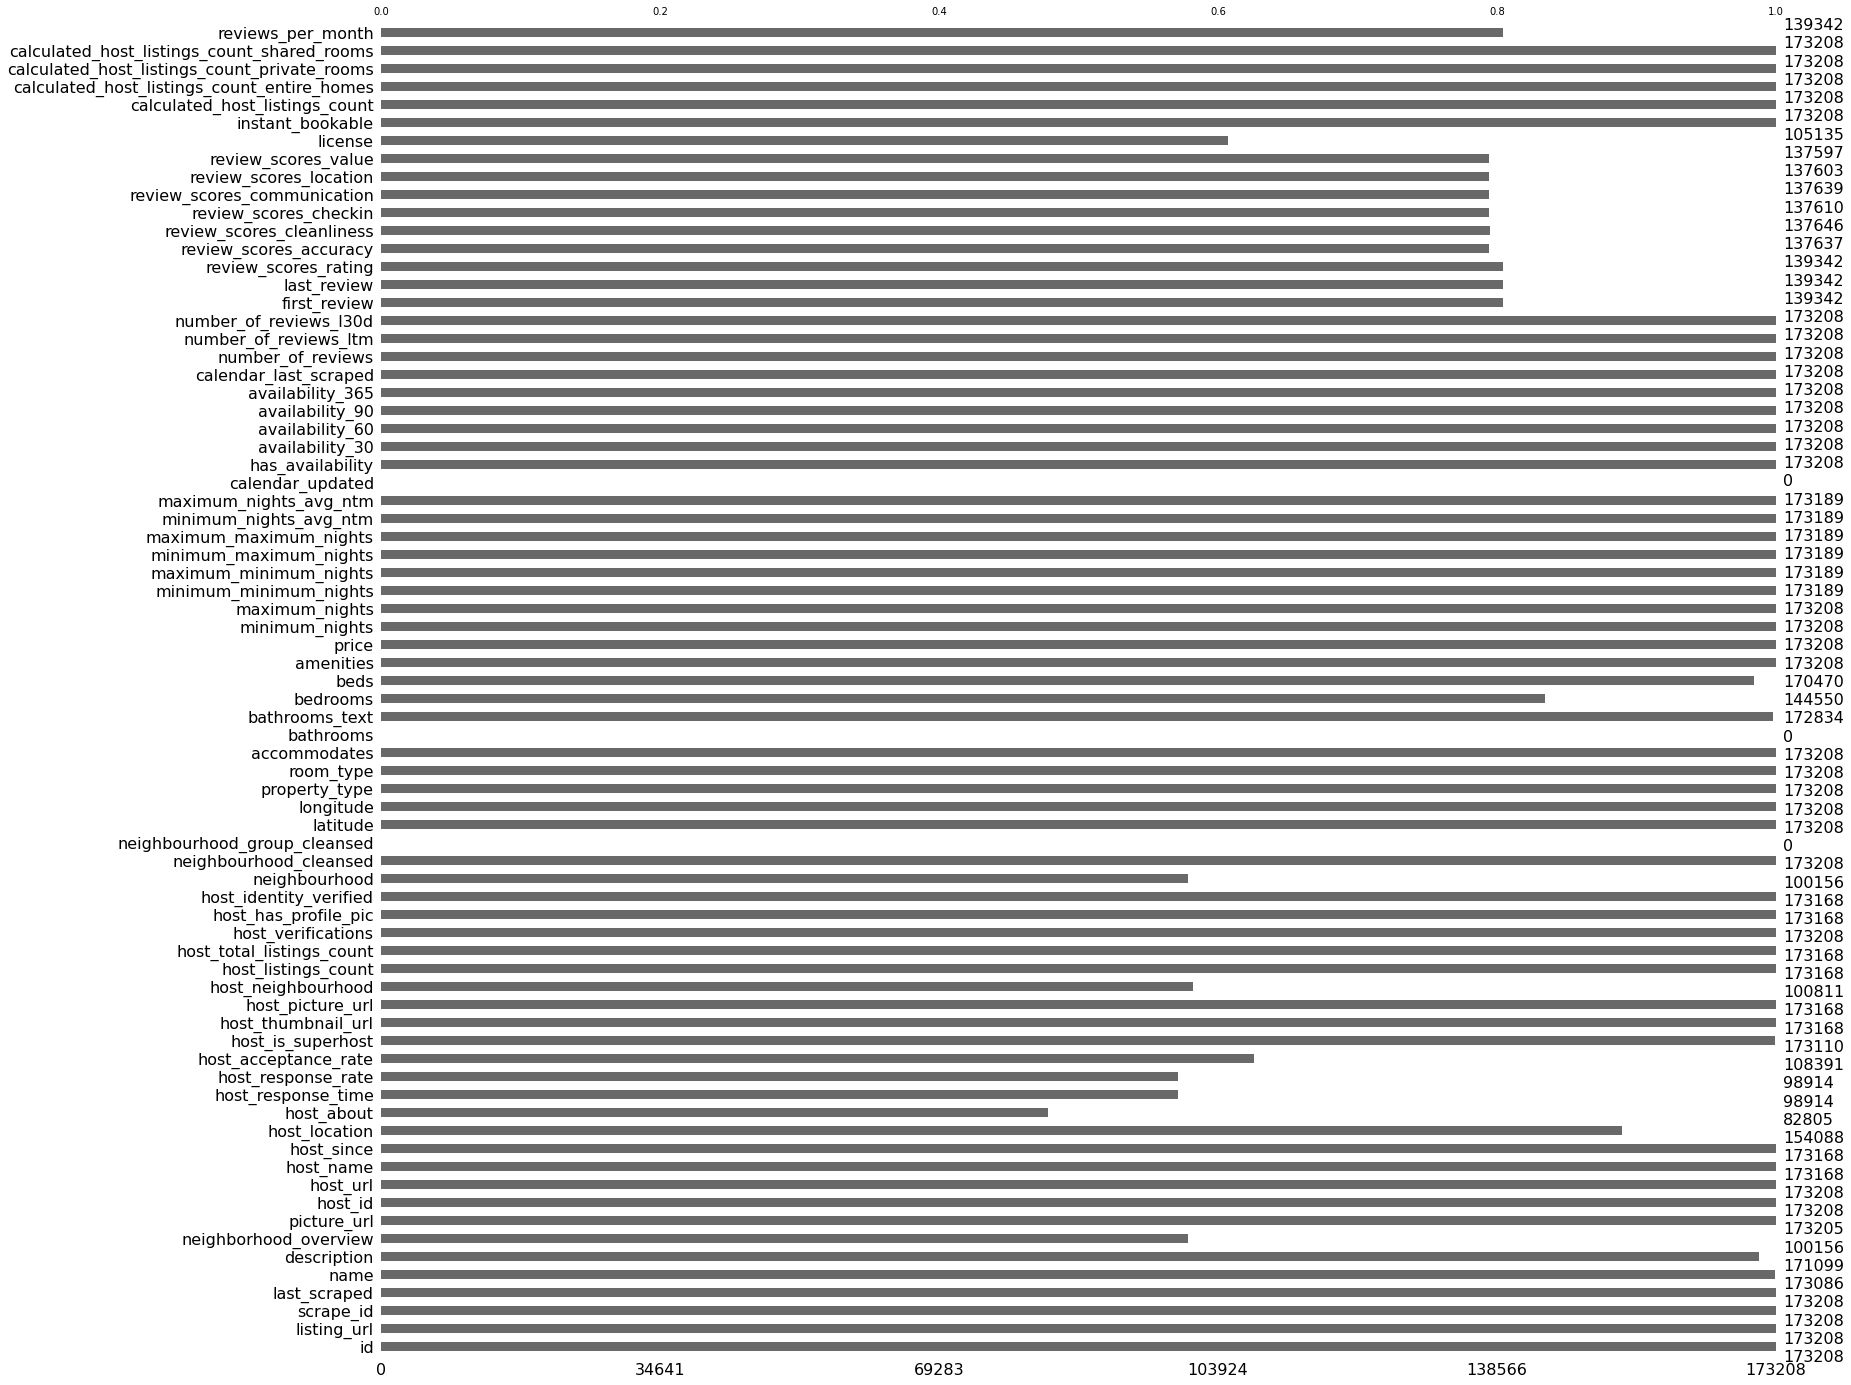

In [ ]:
# Visualize the number of missing data from each feature 
msno.bar(df_paris)
name = 'msno_featureschart'
plt.savefig(os.path.join(plots_dir, f'{name}.png'), bbox_inches='tight',
                    format='png')

In [ ]:
# Missing features
df_paris.isnull().mean(axis=0).sort_values(ascending=False).head(10)

neighbourhood_group_cleansed    1.000000
bathrooms                       1.000000
calendar_updated                1.000000
host_about                      0.521933
host_response_rate              0.428929
host_response_time              0.428929
neighborhood_overview           0.421759
neighbourhood                   0.421759
host_neighbourhood              0.417977
license                         0.393013
dtype: float64

### 4.1.1 Drop features with insuficient information

In [ ]:
# Drop features with missiing infor mation for 35% of the listings
cols_to_drop = df_paris.columns[df_paris.isnull().mean(axis=0)> 0.35]
df_paris.drop(cols_to_drop, axis=1, inplace=True)

### 4.2 Features with missing data

In [ ]:
missing_features, unique_misses = data_summary(df_paris, name='col-drop-hist')

Accomodations: 173208 | Unique accomodations: 73122
Dataset features including id: 63 | Accomodations missing features: 173208


**Add histo**
From the histogram of missing features we can observe that most of the accomondations have 12 or less missing features. We will use this number to filter the data and remove the instances with more than 12 missin features. Then we will further proceed to the data engineering and feature selection and dimessionality reduction.

In [ ]:
#  Find the accommodation with more than 12 missing features
print(f'Accomodations with more than 12 missing features: {len(df_paris[missing_features > 12].index)}')

Accomodations with more than 12 missing features: 171


In [ ]:
# Use the threshold to drop accomodations with more than 12 Nan columns (features) 
threshold = len(df_paris.columns) - 12
df_paris.dropna(thresh=threshold, inplace=True)

### 4.3 Removing features

---
*   Remove host information from the dataset
*   Remove _minimum_maximum_nights_, _maximum_maximum_nights_, _minimum_minimum_nights_ _maximum_minimum_nights_, _minimum_nights_avg_ntm_', '_maximum_nights_avg_ntm_'
*   maximum and minimun nights will be used for the visualisation and analytics

---

- Neighbourhoods with most hosts **Buttes-Montmartre**, **Popincour**, **Passy** 
- Neighbouhoods with smallest number of hosts **Louvre**, **Palais-Bourbon**, **Luxembourg** and **Élysée**. 

In [ ]:
# Remove columns
host_col = ['host_id', 'host_name', 'host_location', 'calendar_last_scraped', 'host_url', 
            'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
            'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
df_paris.drop(host_col, axis=1, inplace=True)

In [ ]:
# msno.dendrogram(df_paris)


## 5. Data Cleaning & Wrangling

### 5.1 Non-categorical features

In [ ]:
from pandas.tseries.offsets import DateOffset

In [ ]:
# Find the nan non-categorical features in the dataset
df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0)

id                                                  0
scrape_id                                           0
last_scraped                                        0
host_since                                         16
host_listings_count                                16
host_total_listings_count                          16
latitude                                            0
longitude                                           0
accommodates                                        0
bedrooms                                        28519
beds                                             2630
minimum_nights                                      0
maximum_nights                                      0
availability_30                                     0
availability_60                                     0
availability_90                                     0
availability_365                                    0
number_of_reviews                                   0
number_of_reviews_ltm       

#### 5.1.2 Drop Features
## **Tasks**

---

Remove information cover under has_availability  maximum_ninghts and minimum_nights

**Availability**

- availability_30                                     
- availability_60                                     
- availability_90                                     
- availability_365

**Counts**

- host_listings_count                                
- host_total_listings_count
- calculated_host_listings_count                      
- calculated_host_listings_count_entire_homes         
- calculated_host_listings_count_private_rooms        
- calculated_host_listings_count_shared_rooms

**scrap_id**
- convert scrap_id to string for filtering pourpose

---



In [ ]:
# Drop instances without host_since information
df_paris.drop(df_paris.host_since[df_paris.host_since.isna()].index, inplace=True)


In [ ]:
# Drop availability columns
drop_avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
drop_columns(drop_avail, df_paris)

# Drop counts
drop_counts = ['host_listings_count', 'host_total_listings_count', 
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 
               'calculated_host_listings_count_shared_rooms']
drop_columns(drop_counts, df_paris)


In [ ]:
# remap the scrape_id to string for filtration
scrape_id = {sc: f'quarter_{i+2}' for i, sc in enumerate(df_paris.scrape_id.unique())}
df_paris['scrape_id'] = df_paris['scrape_id'].map(scrape_id)

### 5.2 Filter active properties  by reviews

### **Tasks**

---

**Reviews**

- first_review is nan and hosted  6 monts before the Q2 2022 scrape date                                  
- last_review a year before the Q2 2022 scrape date                                                                       

---

In [ ]:
# Get the earliest scrape date and substract 6 months
q2_scraped = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=6)).values[0]
# Remove properties with no reviews and host_sice 6 months before the scrapped date Q2-2022 
q2_index = df_paris[(df_paris.first_review.isna()) & (df_paris.host_since < q2_scraped)].index
drop_rows(q2_index, df_paris)


In [ ]:
# Drop properties last reviewed a year before the scrapped date of Q2-2022
q2_last_review = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=12)).values[0]
last_rev_index = df_paris[(df_paris.last_review < q2_last_review)].index
drop_rows(last_rev_index, df_paris)

### 5.3 Categorical features

In [ ]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)

listing_url                 0
scrape_id                   0
name                        2
description               451
picture_url                 0
host_is_superhost          44
host_thumbnail_url          0
host_picture_url            0
host_verifications          0
host_has_profile_pic        0
host_identity_verified      0
neighbourhood_cleansed      0
property_type               0
room_type                   0
bathrooms_text            155
amenities                   0
price                       0
has_availability            0
instant_bookable            0
dtype: int64


## **Tasks**

---
Remove name and description of the listing - for more complex task NLP can beused to process the content extract information and/or sentiment. We would utilise the amenities to extract the listing features 

**Listing description**
*   name 
*   description 

Remove information about the host except identity_verified

**host information**

*   listing_url
*   picture_url
*   host_thumbnail_url
*   host_picture_url 
*   host_verifications - cover in under identity_verified
*   host_has_profile_pic

**identity_verify**

* Drop listings withouth identity verified and last reviewed 6 months before scrapped Q2 2022

**bathrooms_text**

* Drop properties with Nan bathrooms

Reprocess columns content

**Convert text to float**

* bathrooms_text
* price

**Hot encode**

- bathrooms - exract whether is shared or not
- amenities

---



#### 5.3.1 Drop information about the host and the listing name and description

In [ ]:
# Drop name and description and host information
description = ['name', 'description']
drop_columns(description, df_paris)

# Drop name and description and host information
host_info = ['listing_url', 'picture_url', 'host_thumbnail_url', 'host_picture_url', 
                    'host_has_profile_pic', 'host_verifications']
drop_columns(host_info, df_paris)

# Drop listings without bathrooms
bathrooms_idx =df_paris[df_paris.bathrooms_text.isna()].index
drop_rows(bathrooms_idx, df_paris)
        

In [ ]:
# Drop listings withouth identity verified and last reviewed 6 month before scrapped Q2 2022
identity_idx = df_paris[(df_paris.host_identity_verified =='f') & 
                        (df_paris.last_review < q2_scraped)].index
drop_rows(identity_idx, df_paris)

#### 5.3.2 Convert categorical to numerical


**Bathrooms**



In [ ]:
df_paris.bathrooms_text.unique()

array(['1 bath', '1 private bath', '2 baths', '1 shared bath',
       '1.5 baths', '2.5 baths', '3 shared baths', '4 baths',
       'Shared half-bath', '1.5 shared baths', '3.5 baths', '3 baths',
       '2 shared baths', 'Half-bath', '5 baths', '0 shared baths',
       '2.5 shared baths', '0 baths', '8 baths', '4.5 baths', '6 baths',
       'Private half-bath', '50 baths', '6 shared baths', '7 baths',
       '5.5 baths', '6.5 baths', '3.5 shared baths', '4 shared baths',
       '7.5 baths'], dtype=object)

In [ ]:
def clean_bathroom(string):

    string = string.lower().split(' ')
    if '0' in string:
        string = 1
    elif 'half-bath' in string:
        string = 1
    else:
        string = float(string[0])

    return string

In [ ]:
def encoded_bathrooms(df, col_1=None, col_2=None):
    """
    :param df: dataframe 
    :param col_1: column with the text to process
    :param col_2: new clean column
    :return: None
    """
    shared_bathroom = 'shared_bathroom'
    private_bathroom = 'private_bathroom'
    df[col_2] = df[col_1].apply(clean_bathroom)

    d = {shared_bathroom: np.zeros(len(df)),
         private_bathroom: np.zeros(len(df))}

    for i, text in enumerate(df[col_1].values):

        if 'shared' in text:
            d[shared_bathroom][i] = df.iloc[i][col_2]
        else:
            d[private_bathroom][i] = df.iloc[i][col_2]

    df[shared_bathroom] = d[shared_bathroom]
    df[private_bathroom] = d[private_bathroom]

    # Drop bathrooms and bathrooms_text
    drop_columns([col_1, col_2], df)

In [ ]:
encoded_bathrooms(df_paris, col_1='bathrooms_text', col_2='bathrooms' )

In [ ]:
from tqdm import tqdm

**Price**

In [ ]:
def price_to_float(string):
    price = string.split('$')[1].replace(',','')
    return float(price)

In [ ]:
df_paris['price'] = df_paris['price'].apply(price_to_float)

### 5.4 Clean and encode amenities

#### Amenities


### Recommended Essential amenities

https://www.airbnb.co.uk/hospitality#essential-amenities

- Toilet paper
- Soap
- Linens/sheets
- At least one towel per booked guest
- At least one pillow per booked guest


Additional amenities categories include:

https://www.airbnb.co.uk/help/article/586
https://www.airbnb.co.uk/help/article/479


- Bathroom
- Bedroom and laundry
- Entertainment
- Family
- Heating and cooling
- Home Safety
- Internet and office
- Kitchen and dining
- Location features
- Outdoor
- Parking and facilities
- Services
- TV
- free parking. 


In [ ]:
# Find accommoodations with empty amenities "[]" and drop them from the dataset
empty_amenities = df_paris[df_paris["amenities"] == "[]"].index
print(f'Accommodations with empty amenities: {len(empty_amenities)}')
drop_rows(empty_amenities, df_paris)
# df_paris.drop(index=empty_amenities, inplace=True)

Accommodations with empty amenities: 21


#### 5.4.1 Build functions to process amenities 

In [ ]:
# import unidecode
import pickle
from amenities import decode_unicode, common_amenities, preprocess_amenities

In [ ]:
clean_amenities = []
for amenities in df_paris.amenities.values:
    decoded_amenities=decode_unicode(amenities)
    clean_amenities.append(decoded_amenities)


In [ ]:
def unique_amenities(amenities_list):
    for i, l in tqdm(enumerate(amenities_list)):  
        if '' in  l:
            amenities_list[i].remove('')
        amenities_list[i] = list(set(amenities_list[i]))
    return amenities_list
           

In [ ]:
clean_amenities = preprocess_amenities(clean_amenities)
clean_amenities = unique_amenities(clean_amenities)

92728it [00:00, 247222.01it/s]


In [ ]:
df_amenities = common_amenities(clean_amenities)

100%|██████████| 92728/92728 [00:00<00:00, 138860.71it/s]


In [ ]:
print(f'Common amenities: {len(df_amenities)}')

Common amenities: 272


In [ ]:
df_amenities.describe()

,frequency
count,272.000000
mean,8868.955882
std,19260.026064
min,1.000000
25%,3.000000
50%,76.500000
75%,5237.750000
max,88783.000000


#### **Top 10 amenities**

|amenity|frequency|
|---|---|
|wifi|88783|
|kitchen|85683|
|essentials|83260|
|heating|83255|
|long term stays allowed|77452|
|smoke alarm|74465|
|hot water|73666|
|hair dryer|73414|
|dishes and silverware|71057|
|washer|70354|

### **Tail of the amenities**

|amenity|frequency|
|---|---|
|miel|1|
|n’hésitez à demander si vous avez besoin de savon|1|
|books|1|
|ipod dock|1|
|patio|1|
|bluray player|1|
|bose|1|
|liquid|1|
|very good quality|1|
|cien|1|

Text(0.5, 0, 'frequency')

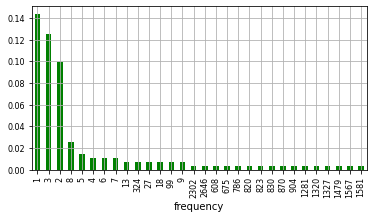

In [ ]:
# Plot the density of the amenities vs frequency 
(df_amenities.frequency.value_counts()[0:30]/len(df_amenities)).plot.bar(color='green', 
                                                                         fontsize=8, figsize=(6,3))
plt.grid()
plt.xlabel('frequency')


In [ ]:
print(f'There are {df_amenities.value_counts()[0:3].sum()} amenities that appear in 3 or less listings')

There are 100 amenities that appear in 3 or less listings




---


- 25 % of the amenities have a frequency of 3 or less 
- 50% of the amenities only appear in 76  or less intances 


---




In [ ]:
# Drop amenities with <= 3 appearance in the df_amenities
amenities_idx = df_amenities[df_amenities.frequency <= 3].index
drop_rows(amenities_idx, df_amenities)

In [ ]:
for am in df_amenities.index:
    if 'years old'in am:
        drop_rows(am, df_amenities)

In [ ]:
# Remove from amenities toilettries brands 
toiletries = ['garnier', 'sanex', 'dove', 'dop', 'uriage', 'savon de marseille']
for item in toiletries:
    if item in df_amenities.index:
        drop_rows(item, df_amenities)

In [ ]:
# Create a dataframe with encoded amenities
amenties_array = np.zeros((len(clean_amenities), len(df_amenities)))
encoded_amenities = pd.DataFrame(data=amenties_array, columns=df_amenities.index)

In [ ]:
# Hot-encoding the encoded_amenities dataframe
for i in tqdm(range(len(clean_amenities))):
    for amenity in df_amenities.index:
        if amenity in clean_amenities[i]:
            encoded_amenities.at[i, amenity] = 1
            

100%|██████████| 92728/92728 [00:58<00:00, 1573.33it/s]


In [ ]:
# Drop the amenities column from df_paris and reset index
drop_columns('amenities', df_paris)
df_paris.reset_index(drop=True, inplace=True)

In [ ]:
# Drop duplicated free weights with fitness
encoded_amenities[['free weights', 'gym or fitness equipment']][encoded_amenities['free weights']==1] 
drop_columns('free weights', encoded_amenities)


In [ ]:
# merged encoded amenities with  df_paris
merged_paris_df = pd.concat([df_paris, encoded_amenities], axis=1)
merged_paris_df.to_pickle('airbnb_paris.pkl')

###  **5.5 Wrangling propery_type and room_type**

In [ ]:
df_paris = pd.read_pickle('airbnb_paris.pkl')

In [ ]:
print(f'Unique types of property in airbnb: {len(df_paris.property_type.unique())}')

print('Examples of property_type include in the dataset')
df_paris.property_type.unique()[0:20]

Unique types of property in airbnb: 65
Examples of property_type include in the dataset


array(['Entire rental unit', 'Private room in condo', 'Entire condo',
       'Private room in guesthouse', 'Private room in rental unit',
       'Private room in loft', 'Entire home',
       'Private room in casa particular', 'Shared room in home',
       'Entire guesthouse', 'Room in aparthotel', 'Room in hotel',
       'Private room in townhouse', 'Entire townhouse',
       'Private room in home', 'Entire villa', 'Houseboat', 'Tiny home',
       'Private room in serviced apartment', 'Entire vacation home'],
      dtype=object)



*   **property_type** may contain information about the **room_type** i.e Room in hotel, hotel; Private room in loft
*   The propety_type will be extracted from the string



In [ ]:
def clean_property(st):
    st = st.lower()
    if 'dome' in st and 'ice' in st:
        st = 'ice dome'
    elif 'farm' in st:
        st = 'farm'
    elif 'nature lodge' in st or 'entire place' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'serviced' in st or 'boutique' in st or 'rental' in st or 'casa' in st or 'suite' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'home' in st and not 'in home':
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'bed and breakfast' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-3:]))
    elif 'boat' in st:
        st = 'boat'
    else: 
        st = st.split(' ')
        if st[-1] == 'room':
            st = ' '.join(map(str, st[-2:]))
        else:
            st = st[-1]
    return st

In [ ]:
# Process property_type
df_paris['property_type'] = df_paris['property_type'].apply(clean_property)

In [ ]:
print('Properties that offer hotel rooms and are neither hotels or boutique hotels:')
df_paris.property_type[(df_paris.room_type == 'Hotel room')  & 
                       (~df_paris.property_type.isin(['hotel', 'boutique hotel']))].unique()

Properties that offer hotel rooms and are neither hotels or boutique hotels:


array(['aparthotel', 'hostel', 'bed and breakfast', 'serviced apartment'],
      dtype=object)

In [ ]:
# Rename private rooms in hotel and in boutique hotel to Hotel rooms and Hotel rooms into Private
# rooms if associated with other accommodations
for i, t in df_paris[['property_type', 'room_type']].iterrows():   
    if t[0] == 'aparthotel' and t[1] == 'Hotel room':
        df_paris.at[i, 'room_type'] = 'Private room'
    elif 'hotel' not in t[0] and t[1] == 'Hotel room':     
        df_paris.at[i, 'room_type'] = 'Private room'
    elif t[1] == 'Private room' and (t[0] == 'hotel' or  t[0] == 'boutique hotel'):
        df_paris.at[i, 'room_type'] = 'Hotel room' 

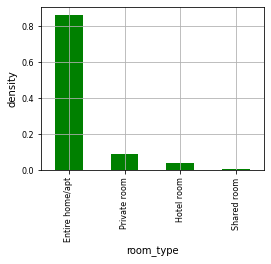

In [ ]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, figsize=(4, 3))
plt.xlabel('room_type')
plt.ylabel('density')
plt.grid()

### **5.6. Fill missing data (NaN)**



---
 **Categorical**

*  host_is_superhost 

---
**Non_categorical**

*   all reviews
*   beds
*   bedrooms
---


#### **5.6.1 Fill nan - categorical**

In [ ]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)

scrape_id                  0
host_is_superhost         13
host_identity_verified     0
neighbourhood_cleansed     0
property_type              0
room_type                  0
has_availability           0
instant_bookable           0
dtype: int64

#### **Superhost**

In [ ]:
df_paris.host_is_superhost.fillna(value='f', inplace=True)

In [ ]:
for k, v in df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0).items():
  if 'review' in k:
    print(f'{k} - {v} misses')

number_of_reviews - 0 misses
number_of_reviews_ltm - 0 misses
number_of_reviews_l30d - 0 misses
first_review - 3258 misses
last_review - 3258 misses
review_scores_rating - 3258 misses
review_scores_accuracy - 3263 misses
review_scores_cleanliness - 3263 misses
review_scores_checkin - 3263 misses
review_scores_communication - 3264 misses
review_scores_location - 3263 misses
review_scores_value - 3263 misses
reviews_per_month - 3258 misses


#### **5.6.2 Fill nan numerical features**

**Beds and bedrooms**

- Fill nan of bed  and bedrooms with by gropuping data with the same  number of beds or beddrooms and accomodates and computing the median
- If the are not similar accomodations and then follow condition minimum 1 up top  accomodates//3 

In [ ]:
def fill_beds_bedrooms(df, filters=None, cols_to_fill=None):
    """
    :param df: data frame
    :param filters: list of columns to filter data
    :param cols_to_fill: columns to fill nan
    :return:
    """

    if cols_to_fill is None:
        cols_to_fill = ['bedrooms', 'beds']
    assert len(filters) == 6, 'the length of filters must be 6'
    assert cols_to_fill == ['bedrooms', 'beds'], "col_to_fill must be ['bedrooms', 'beds']"

    for col in cols_to_fill:

        print('==============================', col, '==============================', sep='\n')
        feat_idx = df[df[col].isna()].index

        for idx in tqdm(feat_idx):
            col_list = df.loc[idx][filters].values

            # Find accommodation with similar features
            if col == 'beds':
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]] == col_list[4]) &
                              (df[filters[5]].notna())].index.values
            else:
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]].notna()) &
                              (df[filters[5]] == col_list[5])].index.values

            # Compute the median
            if fill_idx.size == 0:
                if df.at[idx, filters[3]] <= 3:
                    fill_value = 1
                else:
                    fill_value = df.at[idx, filters[3]]//2
            else:
                fill_value = df.loc[fill_idx][col].median(skipna=True)

            df.at[idx, col] = fill_value


In [ ]:
filtering_features = ['id', 'property_type', 'room_type', 'accommodates',
                    'bedrooms', 'beds']
fill_beds_bedrooms(df_paris, filters=filtering_features)

bedrooms


100%|██████████| 13621/13621 [12:33<00:00, 18.08it/s]


beds


100%|██████████| 1118/1118 [00:58<00:00, 18.99it/s]


#### **5.6.3 Reviews Scores**

In [ ]:
review_cols = [ k for k, v in df_paris[df_paris.columns[df_paris.dtypes == 
                                                    'float64']].isna().sum(axis=0).items() if v >0]

In [ ]:
# Compute Nan per feature
df_paris[review_cols].isna().sum()

review_scores_rating           3258
review_scores_accuracy         3263
review_scores_cleanliness      3263
review_scores_checkin          3263
review_scores_communication    3264
review_scores_location         3263
review_scores_value            3263
reviews_per_month              3258
dtype: int64

In [ ]:
def fillna_per_col_median(df, col_to_fill=None):

    for col in col_to_fill:
        df[col].fillna(value=df[col].median(), inplace=True)

# Fill missing reviews
fillna_per_col_median(df_paris, review_cols)


In [ ]:
# Replace 0 with the median - this are the same inntances that the no reviews
df_paris['number_of_reviews'] = [df_paris.number_of_reviews.median() if n==0 else n 
                                 for n in df_paris.number_of_reviews.values]


In [ ]:
df_paris.to_pickle('paris_clean_df.pkl')

## 6. Price visualisations and filtering



*   Compute percentile and remove the properties with price outside the range p01 > price < p99



In [ ]:
df_paris = pd.read_pickle('paris_clean_df.pkl')

### 6.1 Price stats

In [ ]:
df_paris.price.describe()

count    92728.000000
mean       180.908519
std        460.050931
min          1.000000
25%         83.000000
50%        120.000000
75%        200.000000
max      99140.000000
Name: price, dtype: float64

In [ ]:
print(f'There are {len(df_paris[df_paris.price == 1])} accommodation(s) with price $ 1.')
print(f'The type of properties are : {df_paris.property_type[df_paris.price == 1].unique()} and room {df_paris.room_type[df_paris.price == 1].unique()}')

There are 1 accommodation(s) with price $ 1.
The type of properties are : ['windmill'] and room ['Private room']


In [ ]:
# Find the top k=3 largest prices and drop them from the dataset
print('============== The three largest prices ===========')
print(df_paris.price.nlargest(3))

============== The three largest prices ===========
81873    99140.0
86310    41681.0
78675    14407.0
Name: price, dtype: float64


In [ ]:
# Drop the 3 largest prices and the smallest price from the dataframe
drop_rows(df_paris.price.nlargest(3).index, df_paris)
drop_rows(df_paris[df_paris.price == 1].index, df_paris)

- The minimum price of accomodation is $\$ 1$.  There is 1 listing with $\$ 1$ price.
- Maximum price is $\$ 99140.0$.
- 50 % of the listings have a price of $\$ 120 $ per night and a mean price $ \$ 180.91$.
- 75 % of the accommomodations have a price up to $\$ 200$ per night.
- It is highly certain that the maximum and minimum prices are outliers.

<AxesSubplot:>

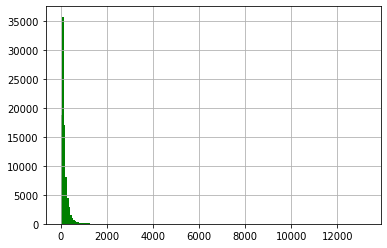

In [ ]:
# Visualise price dstribution
df_paris.price.hist(bins=200, color='green', figsize=(6, 4))

In [ ]:
# Compute percentile for the price to eliminate potential outliers
df_paris.price.quantile([0.005, 0.01, 0.25, 0.5, 0.75, 0.80, 0.90, 0.95, 0.99, 0.995])

0.005      29.0
0.010      34.0
0.250      83.0
0.500     120.0
0.750     200.0
0.800     225.0
0.900     320.0
0.950     447.0
0.990     969.0
0.995    1500.0
Name: price, dtype: float64

- Percentile **1\%** shows a price <= \$34.0
- **Median** price \$120
- **75\%** of the listing have price <= \$200.0
- Percentile **99\%** shows a price <= \$969.86
- The price distribution is skewed to the right

#### 6.1.1 Remove price outliers with percentile


*   Preserving the accommodations within  %1 and 99% range ensure that unique luxurios accommodationes and shared accommodations are cover in the range.



In [ ]:
# Find listings with price less than q01 and greater than q99
q_01 = df_paris.price.quantile(0.01)
q_99 = df_paris.price.quantile(0.99)
q_indices = df_paris[(df_paris.price < q_01) |  (df_paris.price > q_99)].index
# Drop instances
drop_rows(q_indices, df_paris)

In [ ]:
df_paris.price.hist(bins=200, color='green', figsize=(5, 3))
save_plot('price_freq_01_99', x='price', y='frequency')



---




<img align="left" src='figures/price_freq_01_99.jpg' width=500/>

#### 6.1.2 Remove any columns that maybe zero after dropping the quantile

In [ ]:
# Find uniwue types of the features 
df_paris.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')],
      dtype=object)

In [ ]:
def drop_zero_sum_columns(df):
    numeric_cols = df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]
    for col in numeric_cols:
        if df[col].sum() == 0:
            drop_columns(col, df)

drop_zero_sum_columns(df_paris)  

### 6.2  Price filter price by minimum_nights stay

In [ ]:
print('Accommodation minimum_nights stats', 
      '----------------------------------', sep='\n')
df_paris.minimum_nights.describe()

Accommodation minimum_nights stats
----------------------------------


count    90900.000000
mean         8.831903
std         36.826553
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [ ]:
# Find the three longest minimum stay
df_paris.drop_duplicates(subset='minimum_nights').minimum_nights.nlargest(3)

23441    1000
17631     999
12421     500
Name: minimum_nights, dtype: int64

We can observe that:
- 50 % of the listings are short-term stays up to 3 days
- 75% of the listings have a **minimum_nights** of up to 4 nights.
- The maximum in the **minimum_nights** is 1000 equivalent to 2.74 years. This is an indication of an outlier.
<!-- - Listings are markedly split into short term  $<5$ minimum_nights and long term starting from with 30 nights.
- Airbnb is taken over the long term rental - trend -->

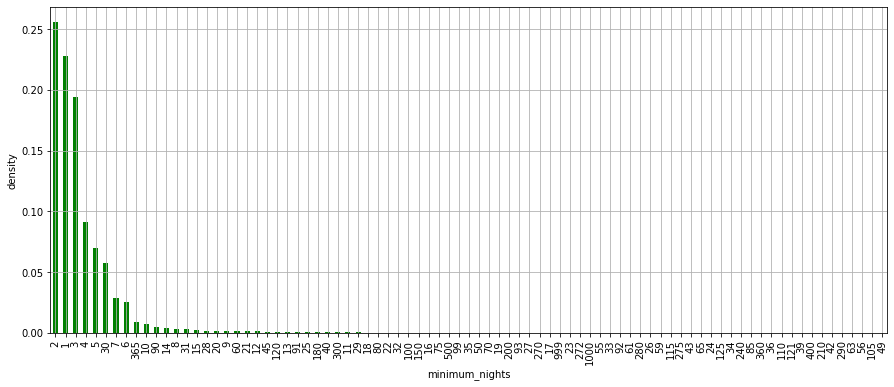

In [ ]:
# Plot bar for minimum_nights counts
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=10, 
                                                                figsize=(15,6))
plt.ylabel('density')
plt.xlabel('minimum_nights')
plt.grid()

In [ ]:
print(f'There are {len(df_paris[df_paris.minimum_nights >= 30])} listings in airbnb Paris that required a minimun_nights stay of 30 nights.')
print(f'The maximum minimun_nights is {df_paris.minimum_nights.max()} ({np.round(df_paris.minimum_nights.max()/365, 2)} years).')
unique_acc = df_paris.id[df_paris.minimum_nights >=30].unique()
unique_id = df_paris.id.unique()
print(f'Unique properties (id) : {len(unique_id)}')
print(f'Unique properties (id) with minimum_nights >= 30: {len(unique_acc)}')
print(f'{round(len(unique_acc)/len(unique_id)*100, 2)}% unique listings from Q2-Q4 2022 required 30 minimum_nights')


There are 7232 listings in airbnb Paris that required a minimun_nights stay of 30 nights.
The maximum minimun_nights is 1000 (2.74 years).
Unique properties (id) : 42605
Unique properties (id) with minimum_nights >= 30: 3723
8.74% unique listings from Q2-Q4 2022 required 30 minimum_nights


In [ ]:
# Compute the quantiles after removing the ouliers
print('Percentile computation for the minimum_nights')
df_paris.minimum_nights.quantile([0.75, 0.80, 0.90, 0.95, 0.99, 0.995, 0.999])

Percentile computation for the minimum_nights


0.750      4.0
0.800      5.0
0.900     10.0
0.950     30.0
0.990    120.0
0.995    365.0
0.999    365.0
Name: minimum_nights, dtype: float64

#### 6.2.1 Drop listing with minimum of nights over 365

In [ ]:
long_term = df_paris.minimum_nights[df_paris.minimum_nights > 365].index.values
drop_rows(long_term, df_paris)
print(f' Size of dataframe after dropping of listings with minimum nights over 365: {len(df_paris)}')

 Size of dataframe after dropping of listings with minimum nights over 365: 90883


In [ ]:
# Drop any potential zero sum coolumns after removinglisting with price over the 99 percentile
drop_zero_sum_columns(df_paris)  

In [ ]:
# Remap to short_term minimum_nights < 30 and long_term for minimum_nights from 30.
df_paris['minimum_nights'] = ['short_term' if  n < 30  else 'long_term' for n in df_paris.minimum_nights.values]

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris.groupby(['minimum_nights'])['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
minimum_nights,,,,,,,,
short_term,83668.0,166.440797,126.456722,34.0,86.0,125.0,200.0,969.0
long_term,7215.0,111.499555,83.055788,34.0,61.0,88.0,131.0,946.0


Text(0, 0.5, 'density')

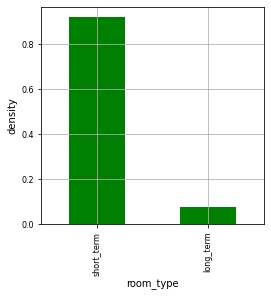

In [ ]:
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, 
                                                                figsize=(4, 4))
plt.grid()
plt.xlabel('room_type')
plt.ylabel('density')


In [ ]:
df_paris[['price', 'minimum_nights']].boxplot(by ='minimum_nights', figsize=(4, 3))
plt.title('')
save_plot('min_nighst_box', x='minimum_nights', y='price')

**8.74\%** of the listings in airbnb required long term stays starting from 30 days

### 6.3 Price filter price by scrape_id




In [ ]:
df_paris.groupby(['scrape_id'])['price'].describe().sort_values(by='mean', 
                                                        ascending=False)

,count,mean,std,min,25%,50%,75%,max
scrape_id,,,,,,,,
quarter_4,30244.0,166.637147,120.085958,34.0,90.0,130.0,200.0,961.0
quarter_3,33641.0,162.985851,128.531087,34.0,81.0,120.0,199.0,969.0
quarter_2,26998.0,155.843285,123.862851,34.0,80.0,116.0,189.0,969.0


In [ ]:
# Plot bar for minimum_nights counts
(df_paris.scrape_id.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8,
                                                            figsize=(2, 2))
# save_plot('quarters_density', x='scraped_id', y='price')
# plt.ylabel('density')
# plt.xlabel('scrape_id')
plt.grid()
save_plot('quarters_density', x='scraped_id', y='price')

In [ ]:
df_paris[['price', 'scrape_id']].boxplot(by='scrape_id', figsize=(4, 3))
plt.title('')
save_plot('scrape_id_box', x='scrape_id', y='price')


---
From the plot and stats we can observe that

*  There are more  more listing advertised in quarter_3 (06-Jun-22 to 09-Sep-22)
*  quarter_q2 (06-March-22 to 06-Jun-22) has the lowest mean price and the smallest number of listings.
---

### 6.4 Price stats by neighboourhood

- All accomodationes appearing in any of the Q2-Q3 2022

In [ ]:
df_paris.groupby(['neighbourhood_cleansed'])['price'].describe().sort_values(by='mean', 
                                                                    ascending=False)

,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Louvre,2290.0,260.123144,178.438956,45.0,135.0,206.0,322.0,969.0
Élysée,2662.0,257.113073,180.359715,35.0,122.0,206.0,350.0,969.0
Palais-Bourbon,2313.0,234.754090,172.945091,34.0,115.0,184.0,292.0,969.0
Luxembourg,2721.0,226.313962,158.491533,35.0,115.0,179.0,290.0,931.0
Hôtel-de-Ville,3190.0,217.970755,143.344483,34.0,119.0,180.0,276.0,926.0
Bourse,3683.0,217.928591,146.324453,36.0,117.0,178.0,276.0,969.0
Temple,4427.0,216.499564,145.142634,34.0,118.0,180.0,268.5,950.0
Opéra,4243.0,195.292145,129.675962,36.0,105.0,160.0,245.0,936.0
Panthéon,3025.0,189.449917,123.147818,35.0,102.0,150.0,240.0,950.0


In [ ]:
(df_paris.neighbourhood_cleansed.value_counts()/len(df_paris)).plot.bar(color='green', 
                                                                fontsize=8, figsize=(6,3))
plt.grid()
save_plot('neighbourhood', x='neighbourhood', y='density')


*   Neighbourhood with mos listings **Buttes-Montmatre**

*   Cheapest neighbourhoods **Ménilmontant** \$101.787, **Buttes-Chaumont** \$116.75, **Reuilly** \$104.93, **Gobelins** \$105.79

*   Most expensive neighbourhoods  are **Élysée** \$260.112, **Louvre** \$257.11 and **Luxembourg** \$234.75.

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'neighbourhood_cleansed']].boxplot(by ='neighbourhood_cleansed', 
                                                      fontsize=10, rot=90, figsize=(12, 4))
plt.title('')
save_plot('neighbourhood_box', x='neighbourhood', y='price')

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3))
# plt.title('')
save_plot('room_type_box', x='room_type', y='price')

### 6.5 Price stats by propety_type

In [ ]:
df_paris.groupby('property_type')['price'].describe().sort_values(by='mean', 
                                                                  ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
floor,3.0,413.333333,11.547005,400.0,410.0,420.0,420.00,420.0
villa,30.0,310.866667,229.408194,34.0,142.0,255.5,390.75,780.0
boutique hotel,2345.0,286.161991,134.976296,58.0,197.0,259.0,344.00,957.0
serviced apartment,971.0,285.181988,183.930006,41.0,153.5,230.0,373.00,969.0
boat,81.0,279.962963,189.076998,40.0,120.0,245.0,390.00,950.0


In [ ]:
(df_paris.property_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, 
                                                               figsize=(6,3))
plt.grid()
save_plot('property_type', x='property_type', y='density')

**Plot here**

<img align="left" src='figures/property_type.jpg' width=500/>

- Most common property_type **rental unit**
- Most expensive property_type **floor**, **villa**, **boutique hotel** and **hotel** (mean price)
- Highest standard deviation \$ 229.41 for **villa**
- Most economical property_type **minsu** 


In [ ]:
# Visualise property_type
df_paris[['price', 'property_type']].boxplot(by ='property_type', 
                                                      fontsize=10, rot=90, figsize=(12, 4))
plt.title('')
save_plot('property_type_box', x='property_type', y='price')

### 6.6 Price vs  room_type

In [ ]:
df_paris.groupby('room_type')['price'].describe().sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Hotel room,3712.0,264.388475,131.583143,41.0,178.0,240.0,319.0,957.0
Entire home/apt,78884.0,164.988480,124.284108,34.0,89.0,125.0,198.0,969.0
Private room,7995.0,89.395819,70.752488,34.0,52.0,70.0,100.0,892.0
Shared room,292.0,65.606164,43.184958,34.0,44.0,57.0,71.0,419.0


In [ ]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, figsize=(3,2))
plt.grid()
save_plot('room_type', x='room_type', y='price')

- Most common type of room **Entire home/apt**
- Most expensive **Hotel room**
- Cheapest **Shared_room**

In [ ]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3))
plt.title('')
save_plot('room_type_box', x='room_type', y='price')

###  6.7 Price grouped by neighboourhood,  property_type, room_type, minimum_nights and scrape_id

In [ ]:
df_paris.groupby(['scrape_id', 'neighbourhood_cleansed', 'property_type', 
                  'room_type', 'minimum_nights'])['price'].describe().head()

count  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term        2.0   
                                                   Private room    short_term        4.0   
                                 bed and breakfast Private room    short_term       11.0   
                                 boat              Entire home/apt short_term        1.0   
                                                   Private room    short_term        1.0   

                                                                                         mean  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights               
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      184.000000   
                                                   Private room    short_term      134.500000   
                                 bed and breakfast Private room    short_term       96.090909   
                                 boat              Entire home/apt short_term      345.000000   
                                                   Private room    short_term       40.000000   

                                                                                         std  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights              
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      55.154329   
                                                   Private room    short_term      52.373658   
                                 bed and breakfast Private room    short_term      55.818374   
                                 boat              Entire home/apt short_term            NaN   
                                                   Private room    short_term            NaN   

                                                                                     min  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      145.0   
                                                   Private room    short_term      106.0   
                                 bed and breakfast Private room    short_term       47.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     25%  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      164.5   
                                                   Private room    short_term      107.5   
                                 bed and breakfast Private room    short_term       64.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     50%  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      184.0   
                                                   Private room    short_term      109.5   
                                 bed and breakfast Private room    short_term       85.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     75%  \
scrape_id neighbourhood_cleansed property_type     room_ty

### 6.8 Drop listing with price over the 99% percentile

In [ ]:
def drop_quantiles(df, col_1=None, col_2=None, col_3=None, col_4=None, col_5=None, 
                   col_6=None, quant=0.99):
    feat1 = df[col_2].unique()
    feat2 = df[col_3].unique()
    feat3 = df[col_4].unique()
    feat4 = df[col_5].unique()
    feat5 = df[col_6].unique()

    for q in tqdm(feat1):
        for n in feat2:
            for p in feat3:
                for r in feat4:
                    for m in feat5:
                        q99 = df[col_1][(df[col_2] == q) & (df[col_3] == n) & 
                                        (df[col_4] == p) & (df[col_5] == r) &
                                        (df[col_6] == m)].quantile(quant)
                        drop_q99 = df[(df[col_2] == q) & (df[col_3] == n) & 
                                    (df[col_4] == p) & (df[col_5] == r) &
                                    (df[col_6]==m) & (df[col_1] >= q99)].index
                        if len(drop_q99) > 0: 
                            df.drop(index=drop_q99, inplace=True)
    print(f'Dataset size after dropping listing with {col_1} > than quantile {quant}: {len(df)}')
                        

In [ ]:
drop_quantiles(df_paris, col_1='price', col_2='scrape_id', col_3='neighbourhood_cleansed', 
               col_4='property_type', col_5='room_type', col_6='minimum_nights', quant=0.99)

In [ ]:
drop_zero_sum_columns(df_paris)  
df_paris.to_pickle('paris_clean_q99.pkl')

### 6.9 Visualisation after droppping percentile 0.99 

In [ ]:
df_paris = pd.read_pickle('paris_clean_q99.pkl')

In [ ]:
# Visualise price vs minimum nights
df_paris[['price', 'minimum_nights', 'room_type']].boxplot(by= ['minimum_nights', 'room_type'],
                                                    rot=90, fontsize=8, figsize=(8, 3))
plt.title('')
save_plot('minimum_nights_room_type_box', x='minimum_nights and room_type', y='price')

In [ ]:
# Visualise price vs minimum nightx
# %matplotlib widget
df_paris[['price', 'neighbourhood_cleansed', 'room_type', 
          'minimum_nights']].boxplot(by= ['neighbourhood_cleansed', 'room_type', 
                                          'minimum_nights'], rot=90, fontsize=10, 
                                        figsize=(17, 8))
plt.title('')
save_plot('neigh_room_type_minimum_nights_box', 
          x='neighbourhood, room_type and minimum_nights', y='price')

In [ ]:
df_paris[['price', 'scrape_id', 'room_type']].boxplot(by= ['scrape_id', 
                                            'room_type'], rot=90, fontsize=10, figsize=(9, 4))
plt.title('')
save_plot('room_type_scrape_id_box', 
          x='room_type and scrape_id', y='price')

In [ ]:
# %matplotlib widget
df_paris[['price', 'property_type', 'room_type']].boxplot(by =['property_type', 'room_type'],
                                                    rot=90, figsize=(12, 6))
plt.title('')
save_plot('property_room_type_box', x='property and room type', y='price')

In [ ]:
df_paris[['price', 'scrape_id', 'neighbourhood_cleansed']].boxplot(by= ['scrape_id', 
                                'neighbourhood_cleansed'], rot=90, fontsize=12, 
                                figsize=(20, 8))
plt.title('')
save_plot('neighbourhood_scrape_id_box', x='neighbourhood_scrape_id', y='price')

In [ ]:
# %matplotlib widget
df_paris[['price', 'neighbourhood_cleansed', 'minimum_nights']].boxplot(
    by=['neighbourhood_cleansed', 'minimum_nights'], rot=90, figsize=(12, 6))
plt.title('')
save_plot('neighbourhood_minimum_nights_box', x='neighbourhood and minimum_nights', y='price')

In [ ]:
df_paris[['price', 'property_type', 'scrape_id']].boxplot(by=
                            ['property_type', 'scrape_id'],rot=90, figsize=(15, 6))
plt.title('')
save_plot('property_scrape_box', x='property_type and scrape_id', y='price')



---


- En general most of the properties are more expensive in quarter_3 and quarte_4.
- Neighbourhoods Élysée and Louvre the mean average highest prices in quarter_3.
- Liating with minimum_nights of 30 of more a cheaper than short-term stays.


---




## 7. Feature selection

**Tasks**
- encode false/true features
- Drop unnecesssary features

In [ ]:
# Reset index
df_paris.reset_index(drop=True, inplace=True)
# Find column dtype object
df_paris.columns[df_paris.dtypes == 'object']

In [ ]:
# Encode binary features
def encoding_binary_features(df, columns=None):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])

features = ['host_is_superhost', 'host_identity_verified', 'minimum_nights']
encoding_binary_features(df_paris, features)

# Hot encoding the left 'object' features
encoded_df  = pd.get_dummies(df_paris)

In [ ]:
# Find potential duplication feature dupplication:
for col in encoded_df.columns:
    if 'coffe'in col or 'espresso' in col:
        print(col)

In [ ]:
encoded_df[['nespresso machine', 'espresso machine', 'nespresso', 'coffe_maker', 'pourover coffee']].sum()

nespresso machine     6914.0
espresso machine       160.0
nespresso              452.0
coffe_maker          60292.0
pourover coffee       2559.0
dtype: float64

In [ ]:
# Group all coffee maker in a new colum and drop duplicated columns
coffee_maker = np.zeros((len(df_paris)))
for i,  v in enumerate(encoded_df[['coffe_maker', 'nespresso machine', 'espresso machine', 
                                   'nespresso', 'pourover coffee']].values):
    if v.any() == 1:
        coffee_maker[i] = 1
encoded_df['coffee_maker'] = coffee_maker
drop_columns(col_list=['coffe_maker', 'nespresso machine', 'espresso machine', 
                                 'pourover coffee'], df=encoded_df)
df_paris.to_pickle('hot_encoded_paris.pkl')

In [ ]:
# move price to the end of the columns
move_price = encoded_df.pop('price')
encoded_df = pd.concat([encoded_df, move_price], axis=1)
encoded_df.to_pickle('hot_encoded_paris.pkl')


### 7.1 Feature correlation

In [ ]:
df_paris = pd.read_pickle('hot_encoded_paris.pkl')

In [ ]:
# Features correlation with the response variable 'price'
corr_matrix = df_paris.corr().abs()
print('Feature correlation with price')
corr_matrix['price'].sort_values(ascending=False)[:10]

Feature correlation with price


price                     1.000000
accommodates              0.544742
beds                      0.353648
bedrooms                  0.332968
crib                      0.315650
private_bathroom          0.272345
tv                        0.247544
dishwasher                0.243985
air conditioning          0.232869
room_type_Private room    0.203260
Name: price, dtype: float64

In [ ]:
corr_matrix = corr_matrix - np.diag(np.diag(corr_matrix))
pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
print('-------------------------', 'correlated pairs', '-------------------------')
pairs.head(10)


------------------------- correlated pairs -------------------------


bedroom comforts           bathroom essentials             1.000000
review_scores_value        review_scores_rating            0.845291
review_scores_rating       review_scores_accuracy          0.836963
bedrooms                   private_bathroom                0.801508
                           beds                            0.794748
room_type_Private room     room_type_Entire home/apt       0.794693
room_type_Hotel room       property_type_boutique hotel    0.788649
review_scores_checkin      review_scores_communication     0.782298
review_scores_accuracy     review_scores_value             0.780957
review_scores_cleanliness  review_scores_rating            0.775072
dtype: float64

### 7.2  Partitioning dataset to run the feature selection algorithms

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectPercentile

In [ ]:
X = df_paris.iloc[:, 0:-1]
y = df_paris['price'].astype('float32')
seed = 123

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30,
                                                  random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.6,
                                                random_state=seed)



### 7.3 Selecting feature with Scikit-learn

#### 7.3.1 SelectKBest with f_regression

In [ ]:
# feature selection
f_selector = SelectKBest(score_func=f_regression, k=50)
# learn relationship from training data
f_selector.fit(X_train, y_train)
# Get the best K features applying f_regression score function
filter_cols = f_selector.get_support()
col_index = np.where(filter_cols == True)[0]
best_reg = pd.Series(f_selector.scores_[col_index])
best_reg.index = f_selector.get_feature_names_out()
best_reg.sort_values(ascending=False)[0:20]

accommodates                     26149.009933
beds                             10386.626178
bedrooms                          7883.896889
crib                              6801.481502
private_bathroom                  5323.686770
tv                                4045.878353
dishwasher                        3965.150692
air conditioning                  3536.485194
room_type_Private room            2684.009557
high chair                        2463.995539
fire extinguisher                 2426.149775
room_type_Hotel room              2123.892155
property_type_boutique hotel      1998.042270
hair dryer                        1919.213454
dryer                             1834.967350
shared_bathroom                   1617.185595
iron                              1526.131559
cable                             1509.619664
neighbourhood_cleansed_Élysée     1429.126729
building staff                    1358.332918
dtype: float64

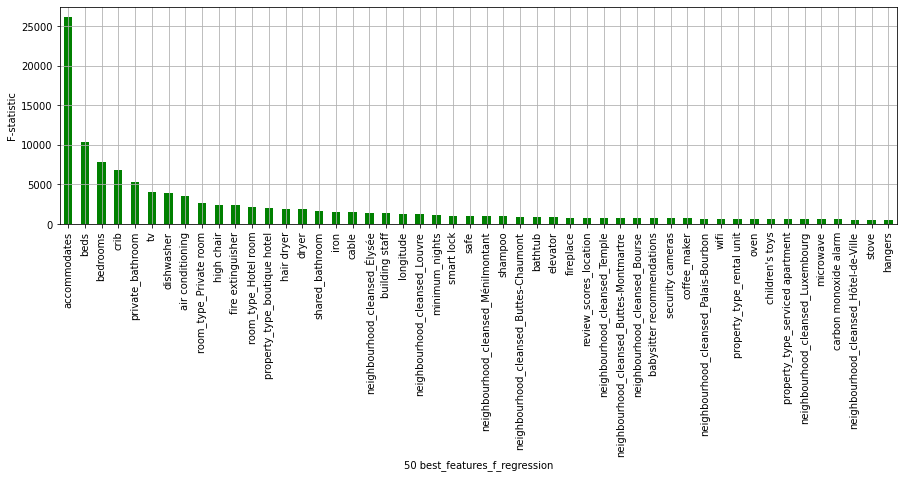

In [ ]:
best_reg.sort_values(ascending=False).plot.bar(figsize = (15, 4), color='green')
plt.xlabel('50 best_features_f_regression')
plt.ylabel('F-statistic')
plt.grid()

### 7.3.2 SelectKBest with mutual_info_regression

In [ ]:
# Get the fest K feature - f_mutual_info score function
features_selected = SelectKBest(score_func=mutual_info_regression, k=50) 
features_selected.fit_transform(X_train, y_train)
filter = features_selected.get_support()

# Get the fest K features - mutual information
mutual_index = np.where(filter == True)[0]
mutual_info = pd.Series(features_selected.scores_[mutual_index])
mutual_info.index = features_selected.get_feature_names_out()
mutual_info.sort_values(ascending=False)[0:20]

longitude                      0.433885
latitude                       0.431181
accommodates                   0.221616
reviews_per_month              0.155762
private_bathroom               0.155299
bedrooms                       0.150115
beds                           0.148274
review_scores_value            0.147277
review_scores_cleanliness      0.145724
review_scores_rating           0.136991
review_scores_location         0.117049
review_scores_checkin          0.110880
review_scores_accuracy         0.110684
review_scores_communication    0.110196
crib                           0.056523
room_type_Private room         0.056341
tv                             0.052728
dishwasher                     0.046978
shared_bathroom                0.046449
room_type_Hotel room           0.041771
dtype: float64

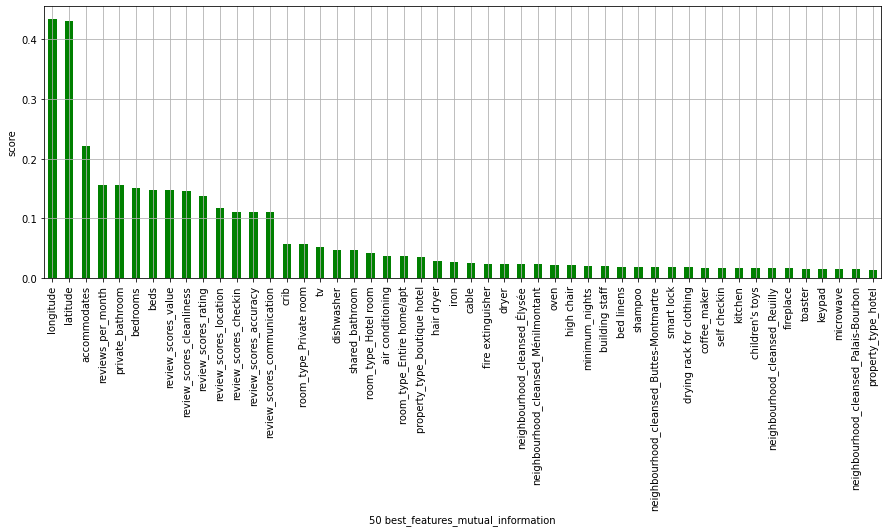

In [ ]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15, 5), color='green')
plt.xlabel('50 best_features_mutual_information')
plt.ylabel('score')
plt.grid()


#### 7.3.3 SelectPercentile with mutual_info_regression

In [ ]:
from sklearn.feature_selection import SelectPercentile
top_percent_cols = SelectPercentile(mutual_info_regression, percentile=50)
top_percent_cols.fit(X_train, y_train)
percentile_index = np.where(top_percent_cols.get_support())[0]
best_percent = pd.Series(top_percent_cols.scores_[percentile_index])
best_percent.index = top_percent_cols.get_feature_names_out()
best_percent.sort_values(ascending=False)[0:10]


longitude                    0.433663
latitude                     0.431766
accommodates                 0.213675
private_bathroom             0.157911
reviews_per_month            0.155850
bedrooms                     0.148247
review_scores_cleanliness    0.146284
review_scores_value          0.146060
beds                         0.145702
review_scores_rating         0.139772
dtype: float64

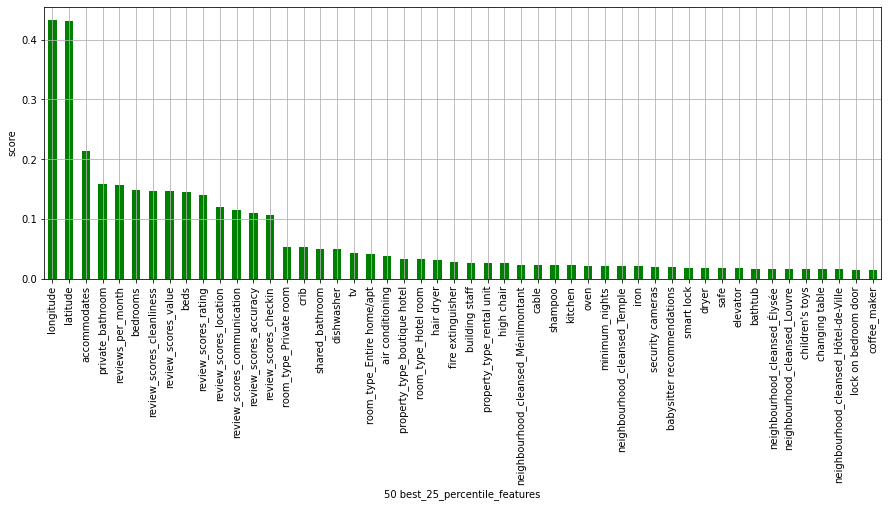

In [ ]:
best_percent.sort_values(ascending=False)[0:50].plot.bar(figsize=(15, 5), color='green')
plt.xlabel('50 best_25_percentile_features')
plt.ylabel('score')
plt.grid()



---
 **3 most important features** - SelectKBest with f_regressor

1.   accommodates
2.   beds
3.   bedrooms



---
 **3 most important features** - SelectKBest with mutual_information_regression

1.   latitude
2.   longitude
3.   accommodates


---

 **3 most important features** - SelectKBest with mutual_information_regression

1.   latitude
2.   longitude
3.   accommodates

---
For this task we will use **SelectPercentile with mutual_information_regression**



## 8. Build the training, validation and test pipeline

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EpochScoring, EarlyStopping

torch.manual_seed(123)
torch.cuda.manual_seed(123)

In [ ]:
class PriceRegressor(nn.Module):
    def __init__(self, inputs=None, hidden=None, p=0.2):

        super(PriceRegressor, self).__init__()

        assert len(hidden) == 3, 'hidden must be a list containing three sizes'

        self.input = inputs
        self.hidden = hidden
        self.dropout = nn.Dropout(p)

        self.regressor = nn.Sequential(
            nn.Linear(self.input, self.hidden[0]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[0], self.hidden[1]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[1], self.hidden[2]), 
            nn.ReLU(),   
            nn.Linear(self.hidden[2], 1))
        
    def forward(self, x):

        x = x.type('torch.FloatTensor').to(device)

        out = self.regressor(x)

        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 8.1 Build the models

In [ ]:
def get_models(percentile_index):
    common_params = dict(random_state=123, learning_rate=0.05, max_depth=10,
                         min_samples_leaf=20)
    models = dict()

    # Linear Models
    models['linear_regression'] = LinearRegression()
    models['lasso'] = Lasso(max_iter=1500)
    models['ridge'] = Ridge()

    # Support Vector Machines
    models['svr'] = SVR(C=5, cache_size=500, epsilon=0.2)

    # Decision trees
    models['decision_tree'] = DecisionTreeRegressor(max_depth=10, random_state=123)

    # Ensemble methods
    models['random_forrest'] = RandomForestRegressor(random_state=123, n_estimators=300,
                                                     max_depth=10, min_samples_leaf=20)
    models['gradient_boosting'] = GradientBoostingRegressor(**common_params, n_estimators=300)
    models['hist_gradient_boosting'] = HistGradientBoostingRegressor(**common_params,
                                                                     l2_regularization=0.001)
    models['xgb'] = XGBRegressor(objective='reg:squarederror', learning_rate=0.05,
                                 max_depth=10, n_estimators=500, tree_methd='gpu_exact',
                                 n_gpus=1, predictor='gpu_predictor',
                                 alpha=0.001, max_leaves=2, verbosity=0)
    models['LGBM'] = LGBMRegressor(learning_rate=0.05, max_depth=10,
                                   n_estimators=500, alpha=0.001, max_leaves=2)

    # Shallow neural network
    models['ann_regressor'] = NeuralNetRegressor(module=PriceRegressor,
                                                 module__input=len(percentile_index),
                                                 module__hidden=[512, 512, 256],
                                                 module__p=0.3,
                                                 train_split=None,
                                                 max_epochs=300,
                                                 optimizer=torch.optim.AdamW,
                                                 lr=0.001,
                                                 device=device,
                                                 iterator_train__shuffle=True,
                                                 verbose=0)

    return models

#### 8.5 Helper function, training and evaluation functions

In [ ]:
def ann_datasets(x, y):
    
    x = torch.from_numpy(x.values)
    y = torch.from_numpy(y.values).reshape(-1, 1)

    return x, y

In [ ]:
def evaluation(x, y, model):

    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_percentage_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)

    return r2, mae, mse, rmse, y_pred

In [ ]:
def train_models(train, val, test, model_dir=None, best_features=None, robust_scaler=False,
                 save=False):
    metrics = defaultdict(dict)
    models = get_models(percentile_index=best_features)

    x_train, y_train = train[0][best_features], train[1]
    x_val, y_val = val[0][best_features], val[1]
    x_test, y_test = test[0][best_features], test[1]

    for k, v in tqdm(models.items()):

        print(f'Buiding {k} pipeline')

        if robust_scaler:
            pipe = make_pipeline(RobustScaler(), v)
        else:
            pipe = make_pipeline(StandardScaler(), v)

        if k == 'ann_regressor':

            x_train, y_train = ann_datasets(x_train, y_train)
            x_val, y_val = ann_datasets(x_val, y_val)
            x_test, y_test = ann_datasets(x_test, y_test)

        model = pipe.fit(x_train, y_train)
        r2 = model.score(x_train, y_train)

        # Validation
        v_r2, v_mae, v_mse, v_rmse, v_pred = evaluation(x_val, y_val, model)

        # Test
        t_r2, t_mae, t_mse, t_rmse, t_pred = evaluation(x_test, y_test, model)

        if save:
            filename = os.path.join(model_dir, f'{k}.sav')
            joblib.dump(model, filename)

        metrics[k] = {'train_r2': r2, 'val_r2': v_r2, 'test_r2': t_r2,
                      'mean_yhat_val': v_pred.mean(), 'mean_yhat_test': t_pred.mean(),
                      'val_mae': v_mae, 'test_mae': t_mae, 'val_mse': v_mse,
                      'test_mse': t_mse, 'val_rmse': v_rmse, 'test_rmse': t_rmse}
           
    return metrics

## 9. Train, validation, test and evaluation of the models performance

### 9.1 Train, validation, test and evaluation

In [ ]:
selected_features = top_percent_cols.get_feature_names_out()

In [ ]:
models_dir = os.path.join(os.getcwd(), 'weights')
try:
    os.makedirs(models_dir, exist_ok=False)
except FileExistsError:
    pass

In [ ]:
all_stages_metrics = train_models((X_train, y_train), (X_val, y_val), (X_test, y_test), 
                                  models_dir, selected_features, robust_scaler=True)

In [ ]:
metrics_robust_scaler = pd.DataFrame.from_dict(all_stages_metrics)
metrics_robust_scaler.to_csv('metrics_robust_scaled.csv')

In [ ]:
metrics_robust_scaler = pd.read_csv('metrics_robust_scaled.csv', index_col=[0]).round(4)


---


**Models' metrics**


---


|model|linear\_regression|lasso|ridge|svr|decision\_tree|random\_forrest|gradient\_boosting|hist\_gradient\_boosting|xgb|LGBM|ann\_regressor|
|---|---|---|---|---|---|---|---|---|---|---|---|
|train\_r2|0\.5544|0\.4966|0\.5544|0\.6094|0\.6435|0\.6564|0\.896|0\.7041|0\.9565|0\.8016|0\.9491|
|val\_r2|0\.5568|0\.498|0\.5568|0\.6002|0\.5877|0\.6279|0\.78|0\.6824|0\.803|0\.7422|0\.7845|
|test\_r2|0\.5603|0\.5012|0\.5603|0\.6077|0\.5965|0\.6362|0\.7863|0\.694|0\.8111|0\.7533|0\.7942|
|mean\_yhat\_val|155\.944|156\.1785|155\.9431|142\.8075|155\.889|155\.8143|155\.5398|155\.985|155\.6422|155\.786|145\.6884|
|mean\_yhat\_test|155\.7705|155\.7204|155\.7696|142\.5344|155\.4132|155\.9366|155\.724|156\.0552|155\.6028|155\.7839|145\.4348|
|val\_mae|0\.3843|0\.3997|0\.3843|0\.2811|0\.3434|0\.3332|0\.2425|0\.306|0\.2263|0\.2728|0\.2141|
|test\_mae|0\.3817|0\.3939|0\.3817|0\.2811|0\.3419|0\.332|0\.2418|0\.3029|0\.225|0\.2698|0\.2118|
|val\_mse|5427\.405|6147\.953|5427\.3707|4895\.9498|5049\.7012|4557\.1913|2694\.7748|3889\.0085|2412\.8689|3156\.8245|2639\.4353|
|test\_mse|5252\.9704|5959\.0155|5252\.9621|4687\.2693|4820\.9274|4346\.8873|2553\.1095|3656\.1552|2256\.5164|2947\.1248|2459\.0037|
|val\_rmse|73\.6709|78\.4089|73\.6707|69\.9711|71\.0612|67\.507|51\.9112|62\.3619|49\.121|56\.1856|51\.3754|
|test\_rmse|72\.4774|77\.1947|72\.4773|68\.4636|69\.4329|65\.9309|50\.5283|60\.4661|47\.5028|54\.2874|49\.5883|



### 9.2 Ranking Models

In [ ]:
models_rank = metrics_robust_scaler.copy().T

for col in models_rank: 
    if 'mean' in col:
        pass
    else:
        if 'r2' in col: 
            models_rank[f'rank_{col}'] = models_rank[col].rank(ascending=False) 

        else: models_rank[f'rank_{col}'] = models_rank[col].rank() 
        drop_columns(col, models_rank)
models_rank.to_markdown('models_ranks_robust.md')


---

> **Ranked Models**

---



|model|mean_pred\_val|mean_pred\_test|rank_train\_r2|rank_val\_r2|rank_test\_r2|rank_val\_mae|rank_test\_mae|rank_val\_mse|rank_test\_mse|rank_val\_rmse|rank_test\_rmse|
|---|---|---|---|---|---|---|---|---|---|---|---|
|linear\_regression|155\.944|155\.7705|9\.5|9\.5|9\.5|9\.5|9\.5|10\.0|10\.0|10\.0|10\.0|
|lasso|156\.1785|155\.7204|11\.0|11\.0|11\.0|11\.0|11\.0|11\.0|11\.0|11\.0|11\.0|
|ridge|155\.9431|155\.7696|9\.5|9\.5|9\.5|9\.5|9\.5|9\.0|9\.0|9\.0|9\.0|
|svr|142\.8075|142\.5344|8\.0|7\.0|7\.0|5\.0|5\.0|7\.0|7\.0|7\.0|7\.0|
|decision\_tree|155\.889|155\.4132|7\.0|8\.0|8\.0|8\.0|8\.0|8\.0|8\.0|8\.0|8\.0|
|random\_forrest|155\.8143|155\.9366|6\.0|6\.0|6\.0|7\.0|7\.0|6\.0|6\.0|6\.0|6\.0|
|gradient\_boosting|155\.5398|155\.724|__3\.0__|__3\.0__|__3\.0__|__3\.0__|__3\.0__|__3\.0__|__3\.0__|__3\.0__|__3\.0__|
|hist\_gradient\_boosting|155\.985|156\.0552|5\.0|5\.0|5\.0|6\.0|6\.0|5\.0|5\.0|5\.0|5\.0|
|xgb|155\.6422|155\.6028|__1\.0__|__1\.0__|__1\.0__|__2\.0__|__2\.0__|__1\.0__|__1\.0__|__1\.0__|__1\.0__|
|LGBM|155\.786|155\.7839|4\.0|4\.0|4\.0|4\.0|4\.0|4\.0|4\.0|4\.0|4\.0|
|ann\_regressor|145\.6884|145\.4348|__2\.0__|__2\.0__|__2\.0__|__1\.0__|__1\.0__|__2\.0__|__2\.0__|__2\.0__|__2\.0__|

## 10. Hyper parameter tuning for the 2 best models

### 10.1 Gridsearach for XGBoost

In [ ]:
highest_essemble = [model for model in 
                     models_rank.rank_test_rmse.nsmallest(n=2).keys() if 'ann' not in model][0]
highest_essemble

'xgb'

In [ ]:
def grid_search(models=None, scaler=None, x=X, y=y, model_dir=models_dir):

    assert type(models), 'models must be a dictionary'

    for k, v in tqdm(models.items()):

        print(f'Optimizing {k}')

        pipe = make_pipeline(RobustScaler(), v)
        model = list(pipe.get_params().keys())[4]
        params_grid = {f'{model}__max_depth': [8, 10], 
            f'{model}__n_estimators': [200, 300, 500],
            f'{model}__learning_rate': [0.05, 0.001, 0.0001]}

        grid_search = GridSearchCV(pipe, params_grid, refit=False, 
                                         scoring='neg_root_mean_squared_error',
                                         verbose=1)
        
        grid_search.fit(X, y)

        print(f'Best Score: {abs(grid_search.best_score_)}')
        print(f'Best Hyperparameters: {grid_search.best_params_}')

        filename = os.path.join(model_dir, f'best_{k}_model.sav')
        joblib.dump(grid_search, filename)



In [ ]:
essemble_models =  {k: v for k, v in get_models().items() if k == highest_essemble}

grid_search(models=essemble_models, scaler=RobustScaler(), 
            x=X[selected_features],  y=y, model_dir=models_dir)



  0%|          | 0/1 [00:00<?, ?it/s]

Optimizing xgb
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(alpha=0.001, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=2, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              n

100%|██████████| 1/1 [1:29:55<00:00, 5395.68s/it]

Best Score: -47.38432006835937
Best Hyperparameters: {'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 500}


### Best Score 

---


* RMSE: 47.38

### Best Hyperparameters

---

* learning_rate: 0.05, max_depth: 10, 
* n_estimators': 500